### Importing libraries

In [2]:
from bs4 import BeautifulSoup
import requests
import math
import os
import shutil
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.firefox import GeckoDriverManager
import codecs
from langdetect import detect
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
import json
from numpy import linalg as la
import time
import random
import seaborn as sns
import string
import heapq 
import matplotlib.pyplot as plt
import editdistance
import hw3_functions as f

### Importing Index and vocabulary
In this cell we upload all the intermediate files needed for the query.
These cell must be run to execute the query.

In [3]:
vocabulary,inverted_index, inverted_index_score, d, articles = f.import_files()
n = len(articles)

## 1. Getting data

### 1.1 Downloading htmls

#### Generating *url.txt* file
With this function we generate a text file containing the suffix to be added to https://www.goodreads.com/ url in order to download the html pages.

In [4]:
f.urls()

#### Iterating and downloading files in *url.txt*
For each of the 300 pages we create a folder which name is *page_n*, where *n* is the number of the page.
For each line in the url file we download the corresponding html page and use *BeatifulSoup* to parse it. Then we write a new file which has as a name an integer (zero based) and the *.html* suffix. Finally we move each of this files to their corresponding folder (page number).

In [5]:
f.download()

### 1.2 Parsing HTML files

#### Parsing info from html page
In this section we extract the information that we want from the htmls and store them into a dataframe. Each dataframe is exported as *article_n.tsv* where *n* is an integer, name of the hmtl file it was created from.

In [6]:
f.generate_tsv(range(1,300+1))

#### Fixing broken urls
Some pages returned an error on bookTitle, so we assumed the html was corrupted. We iterate the lines in the *broken_url.txt* previously created and we download those pages again. After this process we only have one missing page, meaning that all the other broken html pages have been reapaired.

In [7]:
f.fix_broken_links()

## 2. Search Engine

### 2.1.1 Build vocabulary and inverted index

#### Vocabulary
Our vocabulary is 0 based and present the "clean" version of all terms that are ecountered in the plot of each file. This object is exported with *json* and can be imported directly as a dictionary.

In [8]:
vocabulary_dict,article_dict, terms_ids = f.build_vocabulary(articles)

#### Inverted index
Our inverted index is zero based and to each term index we associate a list of elements. This object is exported with *json* and can be imported directly as a dictionary.

In [9]:
inverted_index = f.build_inverted_index(vocabulary_dict,article_dict)

### 2.1.2  Execute the query
We find the list of all the articles plots that have all the elements in the query through the *prefiltering* function. Once we have the list, we add each article as a new line to the output dataframe containing the *bookTitle*, *Plot* and *Url* columns. \
Below you can see one example to understand the mechanism of the query function.

In [10]:
start = time.time()
test = f.query('survival games',vocabulary,inverted_index)
end = time.time()

In [11]:
print(f'Time elapsed for query: {end-start} seconds')
test

Time elapsed for query: 0.4762880802154541 seconds


,bookTitle,Plot,Url
0,Halo: First Strike,The Human-Covenant war rages on as the alien ...,/book/show/615921.Halo\n
1,Hunter's Run,"Like so many others, Ramon Espejo ran from th...",/book/show/1282266.Hunter_s_Run\n
2,Indian Hill,A Michael Talbot Adventure: This first story ...,/book/show/13305176-indian-hill\n
3,Bound by Honor,A modern mafia fairytale. Born into one of th...,/book/show/51525075-bound-by-honor\n
4,Fairest,"Mirror, Mirror, on the wall, Who is the Faire...",/book/show/14745338-fairest\n
...,...,...,...
117,Shadow Falling,I was born in a world ruled by gods. This wor...,/book/show/701564.Shadow_Falling\n
118,The End of The Computer,Travel to the edge of The End of the world wi...,/book/show/12488314-the-end-of-the-computer\n
119,Mockingjay,The final book in the ground-breaking HUNGER ...,/book/show/7260188-mockingjay\n
120,Valor,The Banished Lands is torn by war as High Kin...,/book/show/40651803-valor\n


### 2.2.1 Inverted index with score

We create an occurrence matrix in which lines are articles and columns are terms. In here we also produce a new file that store the names of all articles that have a plot, ignoring those which do not have one.

In [12]:
occ_matrix, articles = f.occurrence_matrix(articles)

We use this matrix to build a vector *N* which has the same length as the number of unique terms in vocabulary and that specify the global occurrence of each unique term. 

In [13]:
my_N_vector = f.N_vector(occ_matrix)

We transform the occurrence matrix to a score matrix, keeping the same overall structure.

In [14]:
OMWS = f.matrix_with_score(occ_matrix, my_N_vector)

We also create and store a *d* vector which has the same length as the total number of articles (with plot and valid book title) and specify the value of $\frac{1}{||d||}$ for each article.

In [15]:
my_d_vector = f.d_vector(OMWS)

Finally from this matrix we produce the inverted index with score by iterating each row and column and we store the inverted index in a json file.  \
 \
The structure of this index is a dictionary of dictionaries, so the outer level is: \
    {**term_1** : {articles:scores_term_1}, **term_2** : {articles:scores_term_2}, ... , **term_n** : {articles:scores_term_n}} \
 \
While the inner level for term_1 is: \
{**article_x** : score_x_term_1, **article_y** : score_y_term_1, ... , **article_z** : score_z_term_1}


In [16]:
build_inverted_inverted_index_2 = f.inverted_index_score(OMWS)

### 2.2.2 Execute the query with cosine similarity

Here we define the cosine similarity of each article for a given query. The top K results (k articles with the highest similarity score) will be returned in decreasing order. \
Below we show an example of the top_k_query function, with k=20.

In [17]:
start = time.time()
test = f.top_k_query('hunger games',20)
end = time.time()

In [18]:
print(f'Time elapsed for query: {end-start} seconds')
test

Time elapsed for query: 0.3617281913757324 seconds


,bookTitle,Plot,Url,Similarity
32,Throne of Glass Collection,"Perfect for the Fans of Hunger Games, Game Of...",/book/show/26309016-throne-of-glass-collection\n,0.014158
0,The Hunger Games Trilogy Boxset,"The extraordinary, ground breaking New York T...",/book/show/7938275-the-hunger-games-trilogy-bo...,0.013622
33,"SAMPLER ONLY: Catching Fire (The Hunger Games,...","Against all odds, Katniss Everdeen has won th...",/book/show/20349441-sampler-only\n,0.011133
28,Eeny Meeny,"The ""dark, twisted, thought-provoking"" (#1 Ne...",/book/show/23398806-eeny-meeny\n,0.009505
41,Mockingjay,The final book in the ground-breaking HUNGER ...,/book/show/7260188-mockingjay\n,0.009060
35,The Hunger Games Tribute Guide,The New York Times bestselling Hunger Games i...,/book/show/13027304-the-hunger-games-tribute-g...,0.008510
34,The Dust Lands Trilogy: Blood Red Road; Rebel ...,All three books in the highly praised Dust La...,/book/show/24885710-the-dust-lands-trilogy\n,0.006066
24,Cheating on My Mistress,Carmelo Miller is a retired NBA player who ha...,/book/show/6296341-cheating-on-my-mistress\n,0.004788
3,The Hunger Games,"Could you survive on your own in the wild, wi...",/book/show/2767052-the-hunger-games\n,0.004586
22,Island of Dragons,Twins Alex and Aaron Stowe are put to the ult...,/book/show/23497890-island-of-dragons\n,0.004280


### 3 New score
In order to define a new score we iterate all articles that have all query terms in their plots (as in 2.1 engine), but now we also ask for multiple inputs to define a new score by taking into account some of the other fields. We will use a different metric according to the type of information:

- **Cosine similarity**: for the *plot* (cosine function defined above), which returns a score between 0 and 1. To calculate this similarity we use the "clean" version of the query input (we apply cleaning function defined above).
- **Edit distance**: for the *book title* and the *author*. To calculate this score we use the lower case version of the input, with no additional "cleaning". In order to get a score between 0 and 1 for each field we normalize it.
- **Match ratio**: for *year of pubblication*, *number of ratings*, *rating value* and *number of pages*. To calculate this score we use the inputs as thresholds. So we get a binary result for each of these four fields (1 = match, 0 = no match), then to get a single score from 0 to 1 we divide the number of matches by the number of fields considered. 

The final similarity score will be a normalized sum of these four scores: plot score, title score, book score and match score. In this way we give more weight to the first three fields rather than each of the fields that we consider to be less relevant: year, number of pages, ratings and number of ratings.

Below we provide a user friendly window which allows to specify a different input for each field. If one field is not known the user can simply press "ENTER". Here we provide an example: 

In [19]:
plot_query = input('Type a plot-based query: ') 
author_query = input('Type author name if known, otherwise press ENTER: ') 
title_query = input('Type book title if known, otherwise press ENTER: ') 
year_query = input('Type maximum number of years since publication, otherwise press ENTER: ') 
min_nratings = input('Type minimum number of ratings, otherwise press ENTER: ') 
rate_query = input('Type minimum rate required (1-5), otherwise press ENTER: ') 
min_npages = input('Minimum number of pages required, otherwise press ENTER: ') 
k = input('Number of results in output: ')

Type a plot-based query: survival games
Type author name if known, otherwise press ENTER: suzanne
Type book title if known, otherwise press ENTER: hunger games
Type maximum number of years since publication, otherwise press ENTER: 15
Type minimum number of ratings, otherwise press ENTER: 200
Type minimum rate required (1-5), otherwise press ENTER: 3
Minimum number of pages required, otherwise press ENTER: 200
Number of results in output: 20


In [20]:
start = time.time()
test = f.query_newscore(plot_query,title_query,author_query,year_query,min_nratings,rate_query,min_npages,k)
end = time.time()

In [21]:
print(f'Time elapsed for query: {end-start} seconds')
test

Time elapsed for query: 1.0122475624084473 seconds


,bookTitle,Plot,Url,Similarity
93,The Hunger Games,"Could you survive on your own in the wild, wi...",/book/show/2767052-the-hunger-games\n,0.308491
87,Wicked Games,Abby Lewis never pictured herself on the surv...,/book/show/10719342-wicked-games\n,0.206833
104,The Ballad of Songbirds and Snakes,It is the morning of the reaping that will ki...,/book/show/51901147-the-ballad-of-songbirds-an...,0.177233
46,The Gender Game,For fans of The Hunger Games and Divergent co...,/book/show/31131467-the-gender-game\n,0.173720
98,The Quillan Games,LET THE GAMES BEGIN.... Quillan is a territor...,/book/show/215540.The_Quillan_Games\n,0.162878
49,Catching Fire,SPARKS ARE IGNITING. FLAMES ARE SPREADING. AN...,/book/show/6148028-catching-fire\n,0.157482
41,The War of Mists,She chose to die in her sister's place and ye...,/book/show/6655491-the-war-of-mists\n,0.156313
44,Dom Wars: Round Six,"When Gladiator Inc, an adult toy company expa...",/book/show/22912730-dom-wars\n,0.154022
25,The Slave Players,It’s modern day in the Deep South. Racial unr...,/book/show/48925302-the-slave-players\n,0.137528
47,Start the Game,Twelve players set off through the online wor...,/book/show/25963370-start-the-game\n,0.136084


The new_score query is running a more complex query, and it takes more than twice the time it took to run the other similarity query. Anyway we think that for the level of query precision that it allows, one second is still a reasonable time.

## 4. Plot 

Below we provide a code to visualize the cumulative number of pages of the first ten books series.

In [22]:
all_cum_pages,all_years = f.cumulative_pages(articles)

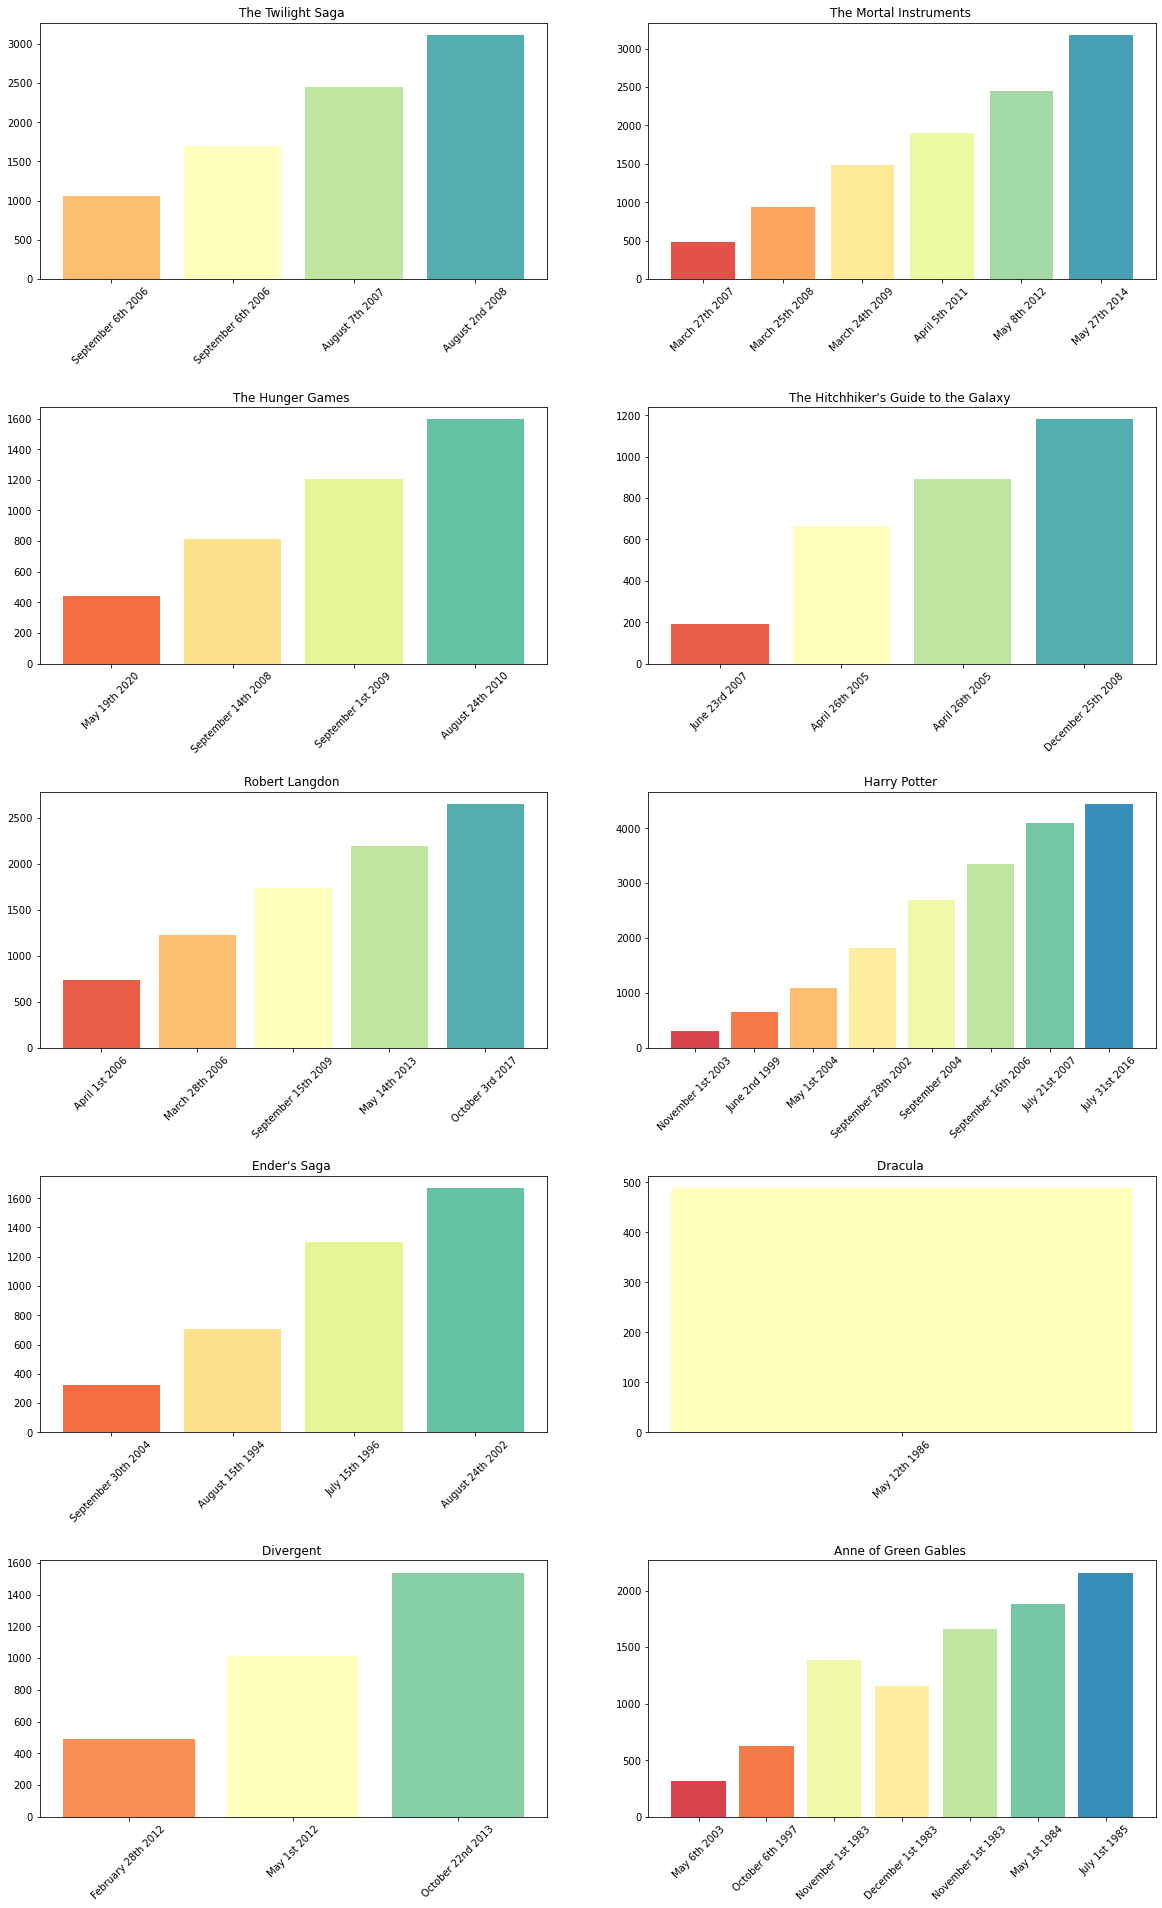

In [23]:
import warnings
warnings.filterwarnings('ignore') 

fig, axs= plt.subplots(5, 2,figsize=(20,33),squeeze=False)
fig.subplots_adjust(hspace=0.5)
n=0 # will be used to assign plot position in grid
for series in sorted(all_cum_pages.keys(),reverse=True):
    y = all_cum_pages[series]
    x = all_years[series]
    pal = sns.color_palette("Spectral",len(y))
    axs[int(n/2), n - int(n/2)*2].bar(x,y,color = pal);
    axs[int(n/2), n-int(n/2)*2].title.set_text(series)
    axs[int(n/2), n-int(n/2)*2].set_xticklabels(x, rotation=45);
    n += 1

## 5. Algorithmic question

Here we look for the length of the common longest subsequence between the alphabet string with a recursive algorithm and with a dynamic programming algorithm.

In [34]:
x = range(2,18,3)
time1, time2, results1, results2, strings = f.run_algorithms(x)

In [42]:
print(f'The radomized strings that we obtained are:')
print(*strings,sep='\n')

The radomized strings that we obtained are:
PO
ZCDOO
TVMAHTXJ
TSIVFLXFYHL
GYOECWAYWKUSWY
KFJGWASCTWLGAQUIZ


In [48]:
print('Longest substring length:')
print(f'Recursive algorithm: {results1}')
print(f'Dynamic programming algorithm: {results2}')
print(f'Match:{(len(set(results1).intersection(results2))/len(set(results1)))*100}%')

Longest substring length:
Recursive algorithm: [1, 3, 4, 4, 5, 6]
Dynamic programming algorithm: [1, 3, 4, 4, 5, 6]
Match:100.0%


We can see from the results that both the algorithms return the same substring lenghts for the same strings. Moreover by checking the strings printed above we cas assume that these results are correct also for short strings.

#### Plots
We compare the running time of these two algorithms.

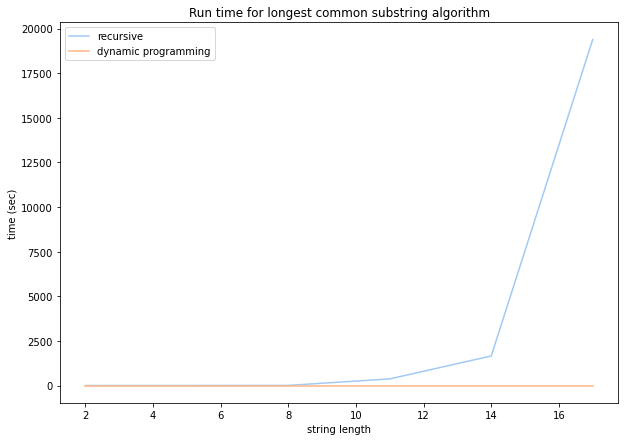

In [44]:
pal = sns.color_palette("pastel",2)
plt.figure(figsize=(10,7))
plt.plot(x,time1,color = pal[0],label = 'recursive')
plt.plot(x,time2,color = pal[1],label = 'dynamic programming')
plt.xlabel('string length')
plt.ylabel('time (sec)')
plt.legend()
plt.title('Run time for longest common substring algorithm')
plt.show()

In order to test the algorithms running time we have generated random strings with length ranging from 2 to 17 (with intervals of 3). We stopped at string length equal to 17, since the recursive algorithm was taking more than five hours to compute the length of the longest common subsequence (20000 seconds). \
In this first plot we want to compare the two algorithms; we can see that the recursive algorithm takes exponential time with incrasing string lengths, while the dynamic algorithm performances do not seem to be afftected by the length of the string. \
Since the scales for running time in the two algorithms are very different, we may want to visualize more in detail how the running time changes for the dyinamic programming algorithm alone. Since the running time is so low we can run more simulations on longer strings (up to 5000).

In [ ]:
x = range(2,5000,100)
time2, results2= f.run_dynamic(x)

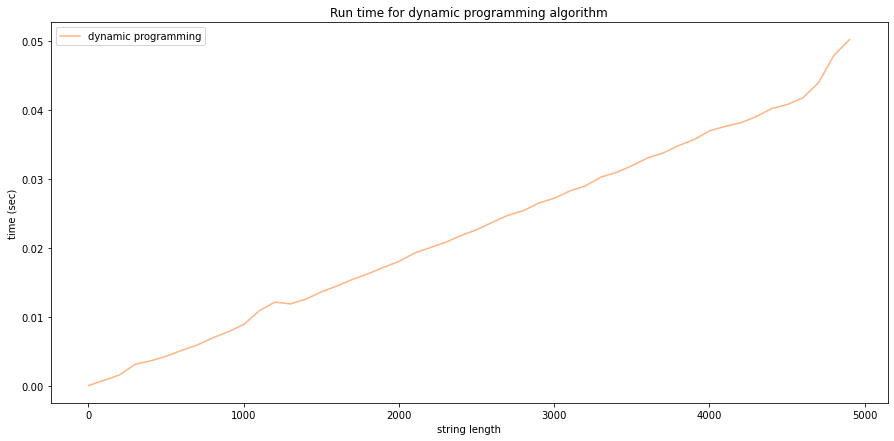

In [21]:
pal = sns.color_palette("pastel",2)
plt.figure(figsize=(15,7))
plt.plot(x,time2,color = pal[1],label = 'dynamic programming')
plt.xlabel('string length')
plt.ylabel('time (sec)')
plt.legend()
plt.title('Run time for dynamic programming algorithm')
plt.show()

From the previous plot it seemed that the dynamic programming algorithm takes constant time, while now we can see that it actually takes linear time event if with a really small slope. \
To conclude we can say that the recursive algorithm takes $O(2^n)$, while the dynamic programming takes $O(n)$. 